In [30]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import norm
from sklearn import linear_model
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

import regex as re
from sklearn.preprocessing import OneHotEncoder


In [136]:
df = pd.read_csv("houses_cleaned_baseline.csv")

In [137]:
df.head()

Unnamed: 0  final_price  bathrooms  parking  \
0           0       855000          2        1   
1           1       885000          2        6   
2           2       550000          1        0   
3           3       665000          1        1   
4           4       825513          2        1   

                                         description           type  \
0  Luxurious And Spacious Murano Tower. 2+1, 2 Ba...      Condo Apt   
1  Fantastic Opportunity To Live Within The Histo...  Semi-Detached   
2  Bright Sunfilled Spacious 1 Bdr Unit; Floor To...      Condo Apt   
3  Rare Loft-Like Condo In Liberty Village W/ 18'...      Condo Apt   
4  Location! Location! Location. Your Cottage In ...       Detached   

                                           full_link  \
0  https://www.zoocasa.com/toronto-on-real-estate...   
1  https://www.zoocasa.com/toronto-on-real-estate...   
2  https://www.zoocasa.com/toronto-on-real-estate...   
3  https://www.zoocasa.com/toronto-on-real-estate...   
4  https://www.zoocasa.com/toronto-on-real-estate...   

                                     full_address        lat       long  \
0      38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1          2 Cabot Crt, Toronto , Ontario, Canada  43.646982 -79.530356   
2    30 Roehampton Ave, Toronto , Ontario, Canada  43.708472 -79.397498   
3   65 East Liberty St, Toronto , Ontario, Canada  43.638399 -79.414448   
4        61 Twelfth St, Toronto , Ontario, Canada  43.597096 -79.509612   

                city_district  mean_district_income  district_code  bedroom  \
0         Bay Street Corridor                 56526             76        2   
1  Islington-City Centre West                 52787             14        3   
2         Mount Pleasant West                 57039            104        1   
3                     Niagara                 70623             82        1   
4                 New Toronto                 44101             18        2   

   den  sqft  
0    1   850  
1    0  1380  
2    0   550  
3    1   650  
4    0   924

### Data Exploration - Part 1

In [138]:
df_eda = df.copy(deep = True)

(25000.0, 200000.0)

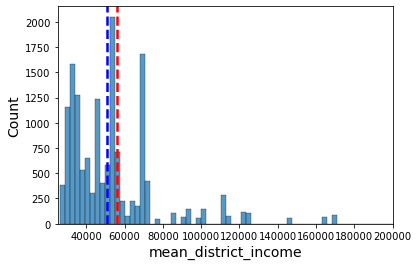

In [139]:
#Applicant income distribution
fig, ax = plt.subplots()

sns.histplot(df_eda['mean_district_income'],ax=ax)
ax.set_xlabel("mean_district_income", size=14)
ax.set_ylabel("Count", size=14)
ax.axvline(x=df.mean_district_income.median(),color='blue',ls='--',lw=2.5,label = 'median')
ax.axvline(x=df.mean_district_income.mean(),color='red',ls='--',lw=2.5, label = 'mean')
ax.set_xlim(25000,200000)

<AxesSubplot:xlabel='sqft', ylabel='final_price'>

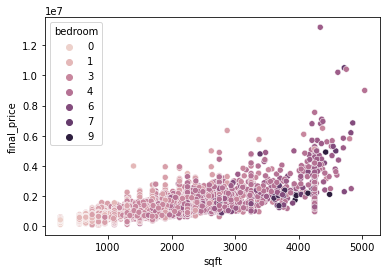

In [140]:
#Sqft vs Final Price wrt number of bedrooms
sns.scatterplot(x='sqft',y='final_price',hue='bedroom', data=df_eda)

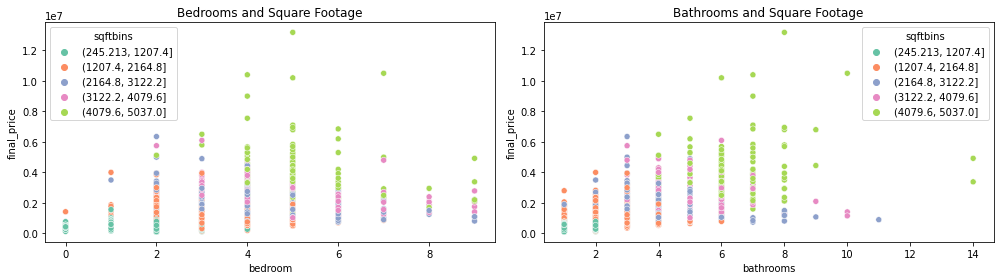

In [141]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

df_eda['sqftbins'] = pd.cut(df_eda["sqft"], bins=5)
sns.scatterplot(data=df_eda, x="bedroom", y="final_price", hue="sqftbins", palette='Set2', ax=ax1)
ax1.set_title('Bedrooms and Square Footage')

sns.scatterplot(data=df_eda, x="bathrooms", y="final_price", hue="sqftbins", palette='Set2', ax=ax2)
ax2.set_title('Bathrooms and Square Footage')

plt.tight_layout()
plt.show()

<Figure size 1152x216 with 0 Axes>

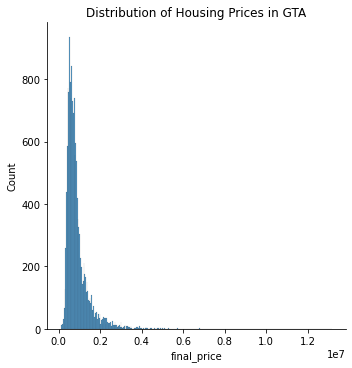

<Figure size 1152x216 with 0 Axes>

In [142]:
sns.displot(df_eda['final_price'])
plt.title('Distribution of Housing Prices in GTA')

plt.figure(5, figsize=[16,3])

C:\Users\bevli\anaconda3\lib\site-packages\seaborn\axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x720 with 0 Axes>

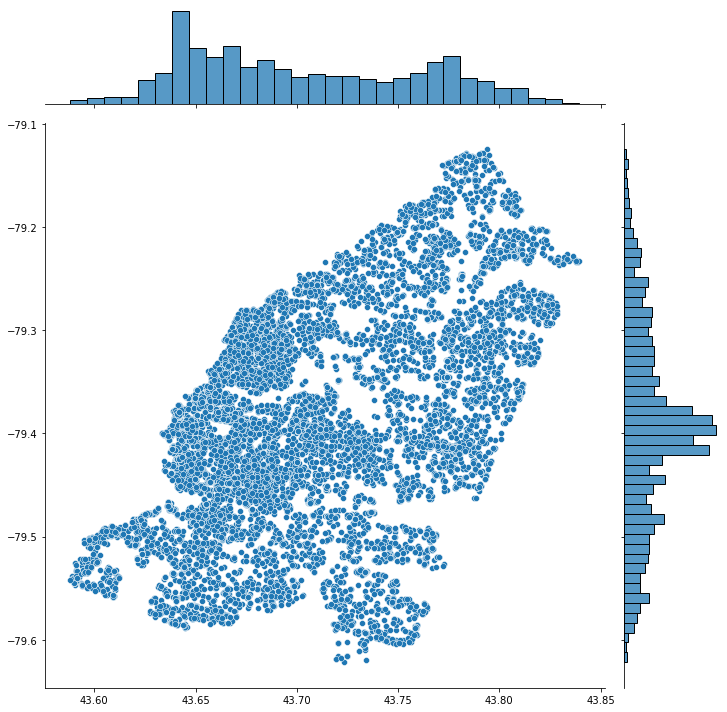

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [143]:
plt.figure(figsize=(10,10))
sns.jointplot(x=df_eda.lat.values, y= df_eda.long.values, size = 10)
plt.ylabel('Longitude')
plt.xlabel('Latitude')
plt.show()
sns.despine

In [144]:
city_districts = df_eda.city_district.unique().tolist()

### Feature Engineering - Part 1

In [145]:
# Neighborhood crime rates obtained from data.torontopolice.on.ca
crime_df = pd.read_csv("Neighbourhood_Crime_Rates_2020.csv")

In [146]:
crime_df

OBJECTID                        Neighbourhood  Hood_ID  \
0           1                       Yonge-St.Clair       97   
1           2              York University Heights       27   
2           3                     Lansing-Westgate       38   
3           4                   Yorkdale-Glen Park       31   
4           5                  Stonegate-Queensway       16   
..        ...                                  ...      ...   
135       136                        Pleasant View       46   
136       137                             Wychwood       94   
137       138                   Leaside-Bennington       56   
138       139                 Briar Hill-Belgravia      108   
139       140  Mimico (includes Humber Bay Shores)       17   

     F2020_Population_Projection  Assault_2014  Assault_2015  Assault_2016  \
0                          14083            16            25            34   
1                          30277           273           298           363   
2                          18146            42            81            67   
3                          17560           106           137           175   
4                          27410            91            74            78   
..                           ...           ...           ...           ...   
135                        16856            34            45            56   
136                        16037            54            72            80   
137                        18627            41            30            38   
138                        15448            79            91            80   
139                        38739           208           206           242   

     Assault_2017  Assault_2018  Assault_2019  ...  Shootings_2020  \
0              25            28            35  ...               0   
1             351           362           382  ...              12   
2              84            68            70  ...               1   
3             163           178           210  ...              14   
4              98            86            83  ...               0   
..            ...           ...           ...  ...             ...   
135            54            46            51  ...               2   
136            54            74            69  ...               2   
137            38            36            32  ...               0   
138            75            91            81  ...               1   
139           339           487           324  ...               2   

     Shooting_Rate2014  Shootings_Rate2015  Shootings_Rate2016  \
0             0.000000            0.000000            7.722008   
1             6.963789            0.000000           13.986990   
2             0.000000            0.000000            5.980146   
3            19.740740           19.752440           19.700550   
4            11.702290            7.788465            0.000000   
..                 ...                 ...                 ...   
135           0.000000           18.367720            6.139866   
136           0.000000            6.798097            0.000000   
137           0.000000            0.000000            0.000000   
138           6.781040            0.000000            6.792094   
139           0.000000            8.931762            2.839054   

     Shootings_Rate2017  Shootings_Rate2018  Shootings_Rate2019  \
0              0.000000            0.000000            0.000000   
1             34.504170           27.189610           20.102520   
2              0.000000            5.737564           11.245430   
3             44.312210           61.042610          100.170900   
4              3.821754            3.759257            3.702744   
..                  ...                 ...                 ...   
135            6.087539            6.035367            0.000000   
136            0.000000            6.481721            6.357279   
137            0.000000            0.000000            0.000000   
138    

In [147]:
#dropping data from 2019 to 2020 as dataset has houses from 2018

crime_df = crime_df[crime_df.columns.drop(list(crime_df.filter(regex='2019')))]
crime_df = crime_df[crime_df.columns.drop(list(crime_df.filter(regex='2020')))]

In [148]:
#Finding averages from 2014 to 2018 for each crime metric and adding to dataframe
crime_df['Assault_Rate'] = crime_df[['Assault_Rate2014',
       'Assault_Rate2015', 'Assault_Rate2016', 'Assault_Rate2017',
       'Assault_Rate2018']].mean(axis = 1)

crime_df['Auto_Theft_Rate'] = crime_df[[ 'AutoTheft_Rate2014', 'AutoTheft_Rate2015', 'AutoTheft_Rate2016',
       'AutoTheft_Rate2017', 'AutoTheft_Rate2018']].mean(axis = 1)

crime_df['Break_andEnter_Rate'] = crime_df[['BreakAndEnter_Rate2014',
       'BreakAndEnter_Rate2015', 'BreakAndEnter_Rate2016',
       'BreakAndEnter_Rate2017', 'BreakAndEnter_Rate2018']].mean(axis = 1)

crime_df['Robbery_Rate'] = crime_df[[ 'Robbery_Rate2014', 'RobberyRate_2015', 'Robbery_Rate2016',
       'Robbery_Rate2017', 'Robbery_Rate2018']].mean(axis = 1)

crime_df['Shootings_Rate'] = crime_df[['Shooting_Rate2014', 'Shootings_Rate2015', 'Shootings_Rate2016',
       'Shootings_Rate2017', 'Shootings_Rate2018']].mean(axis = 1)

In [149]:
crime_df.drop(columns = ['Assault_2014', 'Assault_2015',
       'Assault_2016', 'Assault_2017', 'Assault_2018', 'Assault_Rate2014',
       'Assault_Rate2015', 'Assault_Rate2016', 'Assault_Rate2017',
       'Assault_Rate2018', 'AutoTheft_2014', 'AutoTheft_2015',
       'AutoTheft_2016', 'AutoTheft_2017', 'AutoTheft_2018',
       'AutoTheft_Rate2014', 'AutoTheft_Rate2015', 'AutoTheft_Rate2016',
       'AutoTheft_Rate2017', 'AutoTheft_Rate2018', 'BreakAndEnter_2014',
       'BreakAndEnter_2015', 'BreakAndEnter_2016', 'BreakAndEnter_2017',
       'BreakAndEnter_2018', 'BreakAndEnter_Rate2014',
       'BreakAndEnter_Rate2015', 'BreakAndEnter_Rate2016',
       'BreakAndEnter_Rate2017', 'BreakAndEnter_Rate2018', 'Robbery_2014',
       'Robbery_2015', 'Robbery_2016', 'Robbery_2017', 'Robbery_2018',
       'Robbery_Rate2014', 'RobberyRate_2015', 'Robbery_Rate2016',
       'Robbery_Rate2017', 'Robbery_Rate2018', 'TheftOver_2014',
       'TheftOver_2015', 'TheftOver_2016', 'TheftOver_2017', 'TheftOver_2018',
       'TheftOver_Rate2014', 'TheftOver_Rate2015', 'TheftOver_Rate2016',
       'TheftOver_Rate2017', 'TheftOver_Rate2018', 'Homicide_2014',
       'Homicide_2015', 'Homicide_2016', 'Homicide_2017', 'Homicide_2018',
       'Homicide_Rate2014', 'Homicide_Rate2015', 'Homicide_Rate2016',
       'Homicide_Rate2017', 'Homicide_Rate2018', 'Shootings_2014',
       'Shootings_2015', 'Shootings_2016', 'Shootings_2017', 'Shootings_2018',
       'Shooting_Rate2014', 'Shootings_Rate2015', 'Shootings_Rate2016',
       'Shootings_Rate2017', 'Shootings_Rate2018'],inplace = True, axis = 1)

In [156]:
#check if both dataframes have the exact same neighbourhoods

for i in range(140):
    if (sorted(city_districts)[i] == sorted(crime_df.Neighbourhood)[i]):
        pass
    else:
        print (sorted(city_districts)[i]," - ", sorted(crime_df.Neighbourhood)[i])


Cabbagetown-South St. James Town  -  Cabbagetown-South St.James Town
North St. James Town  -  North St.James Town
Weston-Pelham Park  -  Weston-Pellam Park


In [155]:
df["city_district"].replace({"Cabbagetown-South St. James Town": "Cabbagetown-South St.James Town", "North St. James Town": "North St.James Town", "Weston-Pelham Park": "Weston-Pellam Park"}, inplace=True)

In [157]:
#merging crime DataFrame to EDA DataFrame and original DataFrame
df_eda = pd.merge(df_eda, crime_df, left_on=['city_district'],right_on=['Neighbourhood'], how = 'inner')
df = pd.merge(df, crime_df, left_on=['city_district'],right_on=['Neighbourhood'], how = 'inner')

In [158]:
df

Unnamed: 0  final_price  bathrooms  parking  \
0               0       855000          2        1   
1              85       785000          1        1   
2             154       718000          2        0   
3             161       968000          2        1   
4             216       650000          2        1   
...           ...          ...        ...      ...   
15229       11499      1430000          5        2   
15230       12791       900000          3        4   
15231       14732       805000          4        2   
15232       14950       740000          4        4   
15233       15140       798000          4        4   

                                             description       type  \
0      Luxurious And Spacious Murano Tower. 2+1, 2 Ba...  Condo Apt   
1      Five Condos - Stunning Bright Corner Unit In A...  Condo Apt   
2      Spacious 2 Bedrooms, 2 Full Baths, Over 1000 S...  Condo Apt   
3      Beautiful Burano On Bay Is A Diamond In The Sk...  Condo Apt   
4      *Smart & Functional One Bdrm + Den + Extra Bat...  Condo Apt   
...                                                  ...        ...   
15229  Custom Built! Brand New Never Been Lived!Cover...   Detached   
15230  Immaculate 4 Bed, 3 Bath Raised Bungalow With ...   Detached   
15231  4 Bedroom, 4 Washroom Home In Prestigious High...   Detached   
15232  You Will Love The Location Of This All Brick F...   Detached   
15233  Spacious Immaculate 4 Bedroom In A Prestigious...   Detached   

                                               full_link  \
0      https://www.zoocasa.com/toronto-on-real-estate...   
1      https://www.zoocasa.com/toronto-on-real-estate...   
2      https://www.zoocasa.com/toronto-on-real-estate...   
3      https://www.zoocasa.com/toronto-on-real-estate...   
4      https://www.zoocasa.com/toronto-on-real-estate...   
...                                                  ...   
15229  https://www.zoocasa.com/toronto-on-real-estate...   
15230  https://www.zoocasa.com/toronto-on-real-estate...   
15231  https://www.zoocasa.com/toronto-on-real-estate...   
15232  https://www.zoocasa.com/toronto-on-real-estate...   
15233  https://www.zoocasa.com/toronto-on-real-estate...   

                                       full_address        lat       long  \
0        38 Grenville St, Toronto , Ontario, Canada  43.661896 -79.385748   
1         5 St Joseph St, Toronto , Ontario, Canada  43.665753 -79.385579   
2             633 Bay St, Toronto , Ontario, Canada  43.656674 -79.383443   
3             832 Bay St, Toronto , Ontario, Canada  43.661927 -79.386511   
4       111 Elizabeth St, Toronto , Ontario, Canada  43.655055 -79.384721   
...                                             ...        ...        ...   
15229       33 Cosens St, Toronto , Ontario, Canada  43.796526 -79.173685   
15230       57 Watson St, Toronto , Ontario, Canada  43.786423 -79.173985   
15231      44 Fishery Rd, Toronto , Ontario, Canada  43.791859 -79.175068   
15232   76 Muirbank Blvd, Toronto , Ontario, Canada  43.795167 -79.158194   
15233        4 Lavery Tr, Toronto , Ontario, Canada  43.794767 -79.162195   

       ... OBJECTID        Neighbourhood  Hood_ID   Shape__Area  \
0      ...       94  Bay Street Corridor       76  1.809355e+06   
1      ...       94  Bay Street Corridor       76  1.809355e+06   
2      ...       94  Bay Street Corridor       76  1.809355e+06   
3      ...       94  Bay Street Corridor       76  1.809355e+06   
4      ...       94  Bay Street Corridor       76  1.809355e+06   
...    ...      ...                  ...      ...           ...   
15229  ...       72       Highland Creek      134  5.248058e+06   
15230  ...       72       Highland Creek      134  5.248058e+06   
15231  ...       72       Highland Creek      134  5.248058e+06   
15232  ...       72       Highland Creek      134  5.248058e+06   
15233  ...       72       Highland Creek      134  5.248058e+06   

       Shape__Length  Assault_Rate  Auto_Theft_Rate Br

In [159]:
df.describe()

Unnamed: 0   final_price     bathrooms       parking           lat  \
count  15234.000000  1.523400e+04  15234.000000  15234.000000  15234.000000   
mean    7616.500000  8.827136e+05      2.122227      1.559144     43.702658   
std     4397.821336  6.189336e+05      1.128122      1.345642      0.056806   
min        0.000000  1.030000e+05      1.000000      0.000000     43.588176   
25%     3808.250000  5.350000e+05      1.000000      1.000000     43.652058   
50%     7616.500000  7.150000e+05      2.000000      1.000000     43.690963   
75%    11424.750000  9.890000e+05      3.000000      2.000000     43.755905   
max    15233.000000  1.318000e+07     14.000000     11.000000     43.839372   

               long  mean_district_income  district_code       bedroom  \
count  15234.000000          15234.000000   15234.000000  15234.000000   
mean     -79.394666          56065.642576      71.300643      2.335500   
std        0.095425          32547.705435      38.673608      1.136062   
min      -79.621693          25989.000000       1.000000      0.000000   
25%      -79.454611          34904.000000      39.000000      1.000000   
50%      -79.395589          50580.000000      76.000000      2.000000   
75%      -79.335266          67757.000000     101.000000      3.000000   
max      -79.124094         308010.000000     140.000000      9.000000   

                den          sqft      OBJECTID       Hood_ID   Shape__Area  \
count  15234.000000  15234.000000  15234.000000  15234.000000  1.523400e+04   
mean       0.539583   1315.527767     71.731325     71.300643  6.217339e+06   
std        0.667572    751.379691     40.413891     38.673608  5.669389e+06   
min        0.000000    250.000000      1.000000      1.000000  4.241968e+05   
25%        0.000000    750.000000     40.000000     39.000000  2.480023e+06   
50%        0.000000   1133.500000     71.000000     76.000000  4.784766e+06   
75%        1.000000   1666.000000    103.000000    101.000000  7.464327e+06   
max        6.000000   5037.000000    140.000000    140.000000  3.753449e+07   

       Shape__Length  Assault_Rate  Auto_Theft_Rate  Break_andEnter_Rate  \
count   15234.000000  15234.000000     15234.000000         15234.000000   
mean    12220.953915    710.060529       119.224446           258.241373   
std      6676.231824    469.686694       107.575272           111.497223   
min      2574.408552    123.431522        25.391624            91.711428   
25%      7606.039068    371.637720        71.791840           172.646380   
50%     10750.468290    583.182560        93.681336           226.376580   
75%     15361.246270    841.358840       129.144500           327.742400   
max     43080.724785   2511.640800       975.046860           799.605420   

       Robbery_Rate  Shootings_Rate  
count  15234.000000    15234.000000  
mean     130.031495       10.686355  
std      100.134485       10.543200  
min       10.528852        0.000000  
25%       65.075220        2.805392  
50%      108.759882        8.282310  
75%      160.364920       15.243956  
max      587.762480       58.879640

In [164]:
#Save dataFrame in order to add data from Foursquare
df.to_csv('houses_cleaned_baseline_crimedata.csv')

C:\Users\bevli\AppData\Local\Temp/ipykernel_23048/2564044833.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)


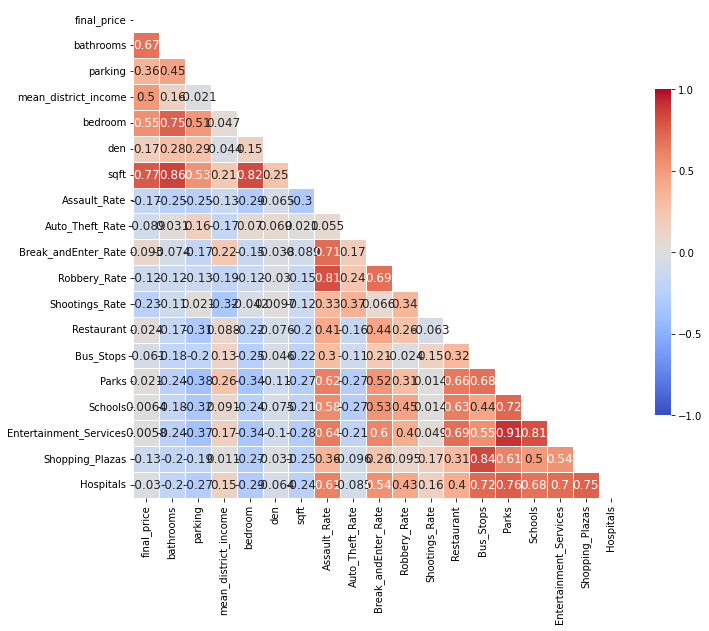

In [25]:
#Create Correlation matrix

corr_matrix = df_model[['final_price','bathrooms', 'parking','mean_district_income',
'bedroom', 'den', 'sqft','Assault_Rate',
'Auto_Theft_Rate','Break_andEnter_Rate','Robbery_Rate',
'Shootings_Rate','Restaurant','Bus_Stops','Parks','Schools',
'Entertainment_Services','Shopping_Plazas','Hospitals']].corr()

f, ax = plt.subplots(figsize=(11, 15))

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

heatmap = sns.heatmap(corr_matrix,
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4,'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 12})

#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

### Modeling - Part 1 

In [3]:
df_model = pd.read_csv("houses_cleaned_baseline_crimedata_foursquare.csv")

In [4]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15234 entries, 0 to 15233
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              15234 non-null  int64  
 1   Unnamed: 0.1            15234 non-null  int64  
 2   final_price             15234 non-null  int64  
 3   bathrooms               15234 non-null  int64  
 4   parking                 15234 non-null  int64  
 5   description             15185 non-null  object 
 6   type                    15234 non-null  object 
 7   full_link               15234 non-null  object 
 8   full_address            15234 non-null  object 
 9   lat                     15234 non-null  float64
 10  long                    15234 non-null  float64
 11  city_district           15234 non-null  object 
 12  mean_district_income    15234 non-null  int64  
 13  district_code           15234 non-null  int64  
 14  bedroom                 15234 non-null

In [8]:
df_model.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'final_price', 'bathrooms', 'parking',
       'description', 'type', 'full_link', 'full_address', 'lat', 'long',
       'city_district', 'mean_district_income', 'district_code', 'bedroom',
       'den', 'sqft', 'OBJECTID', 'Neighbourhood', 'Hood_ID', 'Shape__Area',
       'Shape__Length', 'Assault_Rate', 'Auto_Theft_Rate',
       'Break_andEnter_Rate', 'Robbery_Rate', 'Shootings_Rate',
       'Neighbourhood_Coordin', 'Restaurant', 'Bus_Stops', 'Parks', 'Schools',
       'Entertainment_Services', 'Shopping_Plazas', 'Hospitals'],
      dtype='object')

In [26]:
X = df_model[['bathrooms', 'parking', 'type',
       'Neighbourhood','mean_district_income','bedroom', 'den', 'sqft',
     'Assault_Rate','Auto_Theft_Rate','Break_andEnter_Rate','Robbery_Rate',
       'Shootings_Rate','Restaurant','Bus_Stops','Parks','Schools',
             'Entertainment_Services','Shopping_Plazas','Hospitals']]

y = df_model[['final_price']]

In [27]:
#train test split

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state = 42)

In [31]:
#Column Transformer and Creating Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), ['type','Neighbourhood']),
    ('scaler', MinMaxScaler(), ['bathrooms', 'parking','mean_district_income',
                                'bedroom', 'den', 'sqft','Assault_Rate',
                                'Auto_Theft_Rate','Break_andEnter_Rate','Robbery_Rate',
                                'Shootings_Rate','Restaurant','Bus_Stops','Parks','Schools',
                                'Entertainment_Services','Shopping_Plazas','Hospitals'])])


In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [34]:
#parameters for gridsearch

base_model = LinearRegression()
ridge = Ridge()
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xgb = XGBRegressor()

models = [xgb]

params = [
#     {
#            'models':[ridge],
#            'models__alpha':[0.001,0.01,0.1,1,10]
#           },
#           {
#         'models':[rfr],
#         "models__n_estimators":[100, 150, 200],
#         "models__max_depth":[5,7, 10]
        
#     },
#     {
#         'models':[gbr],
#         "models__learning_rate":[0.1, 0.2, 0.3],
#         "models__n_estimators":[100, 150, 200],
#         "models__max_depth":[5,7, 10]
#     },
    {
        'models':[xgb],
        'models__learning_rate': [0.01, 0.1, 0.4, 0.8],
        'models__colsample_bytree': [0.6, 0.8, 1.0],
        'models__max_depth': [3, 5, 8, 12],
        'models__reg_alpha':[0,0.1,12.8, 51.2],
        'models__n_estimators':[50,100,200,300],
    }]

final_pipeline = Pipeline(steps = [('features',preprocessor),('models',xgb)])


In [35]:
#fitting gridsearchCV

gridsearch = GridSearchCV(final_pipeline, params,scoring = ['neg_mean_squared_error', 'r2'], verbose=5, refit = 'r2').fit(X_train, y_train)


Fitting 5 folds for each of 768 candidates, totalling 3840 fits
[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-495438685658.161) r2: (test=-

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-461927106110.944) r2: (test=-0.389) total time=   0.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-461927136800.816) r2: (test=-0.389) total time=   0.1s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-253496360528.277) r2: (test=0.411) total time=   0.2s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-260775367208.166) r2: (test=0.358) total time=   0.2s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-149056506359.049) r2: (test=0.686) total time=   0.4s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-89839722411.455) r2: (test=0.756) total time=   0.4s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-58207809167.748) r2: (test=0.825) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-67868640341.491) r2: (test=0.842) total time=   0.7s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-505606375425.908) r2: (test=-0.246) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-570049774914.918) r2: (test=-0.203) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-215827536818.474) r2: (test=0.413) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-199123342802.468) r2: (test=0.401) total time=   0.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-225106826339.383) r2: (test=0.477) total time=   0.1s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-94632679796.204) r2: (test=0.767) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-123757273874.163) r2: (test=0.739) total time=   0.4s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-53481082368.549) r2: (test=0.855) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-46664992886.437) r2: (test=0.860) total time=   0.5s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-498180076572.169) r2: (test=-0.157) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-499261758326.759) r2: (test=-0.230) total time=   0.1s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-280638961023.956) r2: (test=0.408) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-209493839834.327) r2: (test=0.431) total time=   0.3s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-194921490823.016) r2: (test=0.414) total time=   0.3s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-69973021076.901) r2: (test=0.838) total time=   0.7s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-88268303157.579) r2: (test=0.783) total time=   0.7s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-86620176158.656) r2: (test=0.817) total time=   1.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51329984567.299) r2: (test=0.860) total time=   1.2s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-442059099549.166) r2: (test=-0.329) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-497032017537.723) r2: (test=-0.154) total time=   0.2s
[CV 5/5] END models=XGBRegressor(b

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-231881133287.249) r2: (test=0.429) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-280210413915.496) r2: (test=0.409) total time=   0.5s
[CV 3/5] END models=XGBRegressor(b

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-71733178745.501) r2: (test=0.805) total time=   1.3s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-62300749141.155) r2: (test=0.813) total time=   1.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-68729008128.271) r2: (test=0.840) total time=   1.2s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-67186057197.478) r2: (test=0.834) total time=   2.0s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-87236380939.046) r2: (test=0.816) total time=   2.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51782964880.192) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51782944377.375) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-51614136825.952) r2: (test=0.845) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-58396950586.808) r2: (test=0.864) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-68181552459.608) r2: (test=0.832) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-75699095207.788) r2: (test=0.840) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-46062784787.023) r2: (test=0.875) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-50534724257.393) r2: (test=0.848) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53921888009.374) r2: (test=0.875) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71128468308.154) r2: (test=0.825) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-71128414316.768) r2: (test=0.825) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-74302331804.047) r2: (test=0.843) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-49288240097.301) r2: (test=0.866) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-43436026026.715) r2: (test=0.869) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47488715967.049) r2: (test=0.890) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-72956248247.517) r2: (test=0.820) total time=   0.8s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-71123111196.898) r2: (test=0.850) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-54546121096.718) r2: (test=0.852) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sco

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-42607368629.675) r2: (test=0.872) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-46000583393.354) r2: (test=0.893) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-75408767958.135) r2: (test=0.814) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-72603566282.620) r2: (test=0.847) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56825732286.660) r2: (test=0.846) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-41533831161.467) r2: (test=0.875) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-45824816800.063) r2: (test=0.894) total time=   0.9s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-76009658651.134) r2: (test=0.813) total time=   0.9s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-76196102088.654) r2: (test=0.839) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-59362342944.294) r2: (test=0.839) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-43375811387.355) r2: (test=0.870) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44809775871.341) r2: (test=0.896) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-73886211294.256) r2: (test=0.818) total time=   0.6s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-75098882242.788) r2: (test=0.842) total time=   1.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-63012517124.226) r2: (test=0.829) total time=   1.2s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-45252163584.110) r2: (test=0.864) total time=   1.6s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-45808563811.077) r2: (test=0.894) total time=   1.6s
[CV 5/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-52516029120.097) r2: (test=0.878) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52516012878.567) r2: (test=0.878) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-52395843069.650) r2: (test=0.878) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52395796363.868) r2: (test=0.878) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-71241083138.314) r2: (test=0.824) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-69350003566.947) r2: (test=0.854) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-53624204753.488) r2: (test=0.854) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-41633920244.285) r2: (test=0.875) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-49447604737.247) r2: (test=0.885) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-72681118180.215) r2: (test=0.821) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-73201691912.194) r2: (test=0.820) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-76893635976.667) r2: (test=0.838) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-51272120558.660) r2: (test=0.861) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-44230658839.199) r2: (test=0.867) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-47895071236.000) r2: (test=0.889) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-73735507933.001) r2: (test=0.818) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-77944084808.898) r2: (test=0.836) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-80306455614.561) r2: (test=0.831) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-60714283666.865) r2: (test=0.835) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-50754038827.978) r2: (test=0.847) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-52509771486.659) r2: (test=0.878) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-81925701586.969) r2: (test=0.798) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-80692365558.834) r2: (test=0.830) total time=   0.9s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-62618381834.004) r2: (test=0.830) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-53491830818.372) r2: (test=0.839) total time=   0.9s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-53684300661.977) r2: (test=0.875) total time=   0.9s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-84702330945.606) r2: (test=0.791) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-82326824737.144) r2: (test=0.826) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-65267339613.673) r2: (test=0.823) total time=   0.5s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-50230962021.668) r2: (test=0.849) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-58590930103.045) r2: (test=0.864) total time=   0.5s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-85920904231.305) r2: (test=0.788) total time=   1.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-84489745423.612) r2: (test=0.822) total time=   1.2s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65970628022.633) r2: (test=0.821) total time=   1.9s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51300749667.962) r2: (test=0.846) total time=   1.8s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-62913193269.531) r2: (test=0.854) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-62913137962.147) r2: (test=0.854) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-78781235467.546) r2: (test=0.806) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-84807812555.414) r2: (test=0.821) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-65534635997.524) r2: (test=0.822) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-44768764522.215) r2: (test=0.865) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-62172860547.140) r2: (test=0.856) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-77585668036.588) r2: (test=0.809) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-82281711449.457) r2: (test=0.826) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-89548139114.615) r2: (test=0.811) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-89547963833.202) r2: (test=0.811) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-70720033519.763) r2: (test=0.808) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-72709734690.647) r2: (test=0.781) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-68085665756.639) r2: (test=0.842) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-88021896802.312) r2: (test=0.783) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-90307896861.710) r2: (test=0.809) total time=   0.6s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-73263870981.689) r2: (test=0.801) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-74993115781.784) r2: (test=0.774) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-64635988526.098) r2: (test=0.806) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-80989504731.636) r2: (test=0.812) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-88822017689.644) r2: (test=0.781) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-98880685219.582) r2: (test=0.791) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-85161612952.589) r2: (test=0.769) total time=   0.7s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-67486232622.979) r2: (test=0.797) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-82619250572.351) r2: (test=0.808) total time=   1.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-90668094591.337) r2: (test=0.777) total time=   1.0s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-109637875936.707) r2: (test=0.769) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-94297720231.066) r2: (test=0.744) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-83630840425.958) r2: (test=0.749) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-90289530079.631) r2: (test=0.790) total time=   0.7s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-100218951470.425) r2: (test=0.753) total time=   0.5s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-110854669004.076) r2: (test=0.766) total time=   1.5s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-96325323918.940) r2: (test=0.738) total time=   1.2s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-84836399510.390) r2: (test=0.745) total time=   2.0s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.6, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-90673196919.118) r2: (test=0.789) total time=   2.1s
[CV 5/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-518448933590.334) r2: (test=-0.204) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-518448947959.844) r2: (test=-0.204) total time=   0.0s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-253876717792.985) r2: (test=0.375) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-308713910502.020) r2: (test=0.349) total time=   0.1s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-87102127328.026) r2: (test=0.763) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-80761009870.049) r2: (test=0.757) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-94349516119.677) r2: (test=0.781) total time=   0.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-79155332172.462) r2: (test=0.805) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-108672804884.600) r2: (test=0.771) total time=   0.4s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-470373628017.727) r2: (test=-0.278) total time=   0.1s
[CV 2/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-470373760377.138) r2: (test=-0.278) total time=   0.1s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-195315543633.742) r2: (test=0.413) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-217510987009.396) r2: (test=0.495) total time=   0.2s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-90248431709.479) r2: (test=0.778) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-121478545582.195) r2: (test=0.744) total time=   0.5s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-51695483368.462) r2: (test=0.859) total time=   0.7s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-46760160821.717) r2: (test=0.859) total time=   0.7s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54096879859.508) r2: (test=0.874) total time=   0.7s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-493236748376.828) r2: (test=-0.215) total time=   0.2s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-557338262274.732) r2: (test=-0.176) total time=   0.2s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-205810658035.717) r2: (test=0.441) total time=   0.4s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-192184796719.930) r2: (test=0.422) total time=   0.4s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-68706475118.977) r2: (test=0.840) total time=   0.8s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-86067683171.625) r2: (test=0.788) total time=   0.8s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-86251838010.809) r2: (test=0.818) total time=   1.3s
[CV 3/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51107987896.000) r2: (test=0.861) total time=   1.3s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44202706772.344) r2: (test=0.867) total time=   1.2s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-491213286747.466) r2: (test=-0.141) total time=   0.3s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-493291379375.044) r2: (test=-0.215) total time=   0.2s
[CV 4/5] END models=XGBRegressor(b

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-275011074535.437) r2: (test=0.420) total time=   0.5s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-205194115428.532) r2: (test=0.442) total time=   0.6s
[CV 2/5] END models=XGBRegressor(b

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-61770990212.977) r2: (test=0.814) total time=   1.4s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-68168285527.779) r2: (test=0.842) total time=   1.4s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-68226862055.835) r2: (test=0.832) total time=   2.4s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-86041143535.978) r2: (test=0.818) total time=   2.3s
[CV 3/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-89249941844.826) r2: (test=0.812) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-89249956239.861) r2: (test=0.812) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-49223985192.186) r2: (test=0.866) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-47410601831.775) r2: (test=0.857) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47410592535.849) r2: (test=0.857) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-53874168574.403) r2: (test=0.875) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69152960316.836) r2: (test=0.830) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-74949498335.273) r2: (test=0.842) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47063002358.076) r2: (test=0.872) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-47746951909.393) r2: (test=0.870) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47746973710.341) r2: (test=0.870) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-41155813978.897) r2: (test=0.876) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-53384020479.926) r2: (test=0.876) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-69678661321.006) r2: (test=0.828) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-72883502394.022) r2: (test=0.846) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-46363294708.787) r2: (test=0.874) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-40234167147.900) r2: (test=0.879) total time=   0.7s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-50862786505.503) r2: (test=0.882) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-74172234165.704) r2: (test=0.817) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-76162936571.168) r2: (test=0.839) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-53485372703.877) r2: (test=0.855) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-46837976440.630) r2: (test=0.859) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-48907844291.285) r2: (test=0.886) total time=   0.7s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-77558239268.859) r2: (test=0.809) total time=   0.8s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-75070576665.654) r2: (test=0.842) total time=   1.1s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-55021782855.400) r2: (test=0.850) total time=   1.0s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-46873326386.291) r2: (test=0.859) total time=   1.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-50108038636.675) r2: (test=0.884) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-75761819691.774) r2: (test=0.813) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-75810916454.615) r2: (test=0.840) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-56406996638.333) r2: (test=0.847) total time=   0.7s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-45750356141.859) r2: (test=0.862) total time=   1.3s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51162354521.799) r2: (test=0.881) total time=   1.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-81487151460.482) r2: (test=0.799) total time=   1.9s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-77784370059.090) r2: (test=0.836) total time=   1.9s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-80010877621.821) r2: (test=0.831) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-80010884165.766) r2: (test=0.831) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-51697189739.197) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51697175532.159) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47159437164.367) r2: (test=0.858) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-52852519616.769) r2: (test=0.877) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-70809223642.771) r2: (test=0.826) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-69869890395.227) r2: (test=0.853) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53030783379.323) r2: (test=0.856) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-52049671218.525) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-52049442437.896) r2: (test=0.859) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-45267457693.190) r2: (test=0.864) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-46522972554.994) r2: (test=0.892) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-70635107454.659) r2: (test=0.826) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-74757517453.604) r2: (test=0.842) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-54572551532.746) r2: (test=0.852) total time=   0.7s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-47854971746.473) r2: (test=0.856) total time=   0.7s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-46968051692.986) r2: (test=0.891) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-75481433466.998) r2: (test=0.814) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-81109262245.962) r2: (test=0.829) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56393685978.400) r2: (test=0.847) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52272865759.893) r2: (test=0.843) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-61460248587.557) r2: (test=0.857) total time=   0.7s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-77831418357.842) r2: (test=0.808) total time=   0.8s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-82680318782.050) r2: (test=0.826) total time=   1.0s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-58744229238.740) r2: (test=0.840) total time=   1.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54495515152.253) r2: (test=0.836) total time=   1.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-63453979194.236) r2: (test=0.853) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-79583722219.571) r2: (test=0.804) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-89200020202.980) r2: (test=0.812) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-56402656263.139) r2: (test=0.847) total time=   0.6s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-48593470207.769) r2: (test=0.854) total time=   1.3s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-63758448143.310) r2: (test=0.852) total time=   1.3s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-80765702413.138) r2: (test=0.801) total time=   1.9s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-89694229142.510) r2: (test=0.811) total time=   1.9s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-88915772596.798) r2: (test=0.812) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-88915705672.668) r2: (test=0.812) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-86241862121.540) r2: (test=0.818) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-51665325334.390) r2: (test=0.860) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-53749138521.773) r2: (test=0.838) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-54961457917.592) r2: (test=0.872) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-81145928423.145) r2: (test=0.800) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-82867246288.386) r2: (test=0.825) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54796630571.365) r2: (test=0.851) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-55993748237.957) r2: (test=0.848) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-55993621971.082) r2: (test=0.848) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-56880388876.072) r2: (test=0.829) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-68169219749.743) r2: (test=0.842) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-89476631684.860) r2: (test=0.780) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-82476221416.170) r2: (test=0.826) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-62547808814.237) r2: (test=0.830) total time=   0.6s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-60381299903.039) r2: (test=0.818) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-69436462399.681) r2: (test=0.839) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-82545899734.674) r2: (test=0.797) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-86168359014.990) r2: (test=0.818) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-70165476959.926) r2: (test=0.809) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-58659609783.078) r2: (test=0.824) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-74578973968.499) r2: (test=0.827) total time=   0.8s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-84031505264.784) r2: (test=0.793) total time=   0.9s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-88485094047.172) r2: (test=0.813) total time=   1.2s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-71254541638.772) r2: (test=0.806) total time=   1.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-61432752939.033) r2: (test=0.815) total time=   1.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-61780710439.483) r2: (test=0.857) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-96891666723.877) r2: (test=0.761) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-93152070935.585) r2: (test=0.803) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-73112888312.532) r2: (test=0.801) total time=   0.7s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-64940153713.358) r2: (test=0.805) total time=   1.5s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-62412564431.500) r2: (test=0.855) total time=   1.4s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-97971172786.447) r2: (test=0.759) total time=   2.3s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=0.8, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-89449903245.337) r2: (test=0.811) total time=   2.4s
[CV 3/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-579974106246.344) r2: (test=-0.224) total time=   0.0s
[CV 3/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-579974117302.969) r2: (test=-0.224) total time=   0.0s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-227528907415.098) r2: (test=0.382) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-210325877739.629) r2: (test=0.367) total time=   0.1s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-244351423423.841) r2: (test=0.433) total time=   0.1s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-107539352270.415) r2: (test=0.735) total time=   0.3s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-142807170325.436) r2: (test=0.699) total time=   0.3s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-62439449080.301) r2: (test=0.830) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=3, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56666421144.053) r2: (test=0.830) total time=   0.5s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-493057564829.932) r2: (test=-0.145) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-496273948135.447) r2: (test=-0.223) total time=   0.1s
[CV 4/5] END models=XGBRegressor(ba

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-278292373379.934) r2: (test=0.413) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-209361221391.804) r2: (test=0.431) total time=   0.2s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-193550987270.188) r2: (test=0.418) total time=   0.2s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-78928922693.396) r2: (test=0.817) total time=   0.6s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-90509980284.232) r2: (test=0.777) total time=   0.5s
[CV 4/5] END models=XGBRegressor(bas

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-89379050633.121) r2: (test=0.811) total time=   0.8s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54124182604.431) r2: (test=0.853) total time=   0.8s
[CV 2/5] END models=XGBRegressor(bas

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-440739288227.764) r2: (test=-0.325) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-485800267268.143) r2: (test=-0.128) total time=   0.2s
[CV 5/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-227176677409.363) r2: (test=0.440) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-272662241395.757) r2: (test=0.425) total time=   0.4s
[CV 3/5] END models=XGBRegressor(ba

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-72640733921.044) r2: (test=0.803) total time=   0.9s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-64380905606.735) r2: (test=0.806) total time=   0.9s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-71030506221.703) r2: (test=0.835) total time=   1.0s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71478122011.311) r2: (test=0.824) total time=   1.6s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-85457303772.562) r2: (test=0.820) total time=   1.6s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-464891418844.667) r2: (test=-0.264) total time=   0.3s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-440735059922.286) r2: (test=-0.325) total time=   0.3s
[CV 1/5] END models=XGBRegressor(b

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-211300662107.075) r2: (test=0.509) total time=   0.7s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-226863844983.475) r2: (test=0.441) total time=   0.7s
[CV 4/5] END models=XGBRegressor(b

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-117650415171.293) r2: (test=0.752) total time=   1.6s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-73887932499.659) r2: (test=0.799) total time=   1.7s
[CV 2/5] END models=XGBRegressor(ba

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-62871412892.264) r2: (test=0.811) total time=   1.6s
[CV 1/5] END models=XGBRegressor(ba

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-49386476561.031) r2: (test=0.885) total time=   2.6s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.01, models__max_depth=12, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-72626232481.871) r2: (test=0.821) total time=   3.3s
[CV 4/5] END models=XGBRegressor(ba

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-70412907512.130) r2: (test=0.827) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-70412861876.920) r2: (test=0.827) total time=   0.0s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-80970854830.512) r2: (test=0.829) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-52430450105.848) r2: (test=0.857) total time=   0.1s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-48097848140.282) r2: (test=0.855) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-54011739459.474) r2: (test=0.875) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-67864223564.842) r2: (test=0.833) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=3, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-74300683077.313) r2: (test=0.843) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-75112779612.149) r2: (test=0.842) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-75112807616.660) r2: (test=0.842) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-49252003984.036) r2: (test=0.866) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-40334729233.387) r2: (test=0.879) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-49920434655.441) r2: (test=0.884) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-67119229711.780) r2: (test=0.835) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-70153430506.310) r2: (test=0.852) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-51558582187.320) r2: (test=0.860) total time=   0.9s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-39425078153.286) r2: (test=0.881) total time=   0.7s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-47366595695.133) r2: (test=0.890) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-76058246503.833) r2: (test=0.813) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-77668156354.705) r2: (test=0.836) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-52918978009.292) r2: (test=0.856) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44991768754.968) r2: (test=0.865) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-45590623316.992) r2: (test=0.894) total time=   1.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-80525903397.416) r2: (test=0.802) total time=   0.8s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-78382735776.980) r2: (test=0.835) total time=   1.2s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=8, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54093051729.747) r2: (test=0.853) total time=   1.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-46926688918.500) r2: (test=0.859) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-48935578824.247) r2: (test=0.886) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-80720801913.498) r2: (test=0.801) total time=   0.8s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-80926872103.950) r2: (test=0.829) total time=   0.8s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-57532932915.895) r2: (test=0.844) total time=   1.5s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-48543321784.031) r2: (test=0.854) total time=   1.7s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-50120646415.162) r2: (test=0.884) total time=   1.6s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-81403230369.214) r2: (test=0.799) total time=   2.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.1, models__max_depth=12, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-82181252492.386) r2: (test=0.827) total time=   2.1s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-64975496575.694) r2: (test=0.823) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_s

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-64975258139.379) r2: (test=0.823) total time=   0.0s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-49076303950.173) r2: (test=0.852) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-49076292503.911) r2: (test=0.852) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-44659882419.177) r2: (test=0.896) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-77701736110.914) r2: (test=0.809) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-77404235120.221) r2: (test=0.837) total time=   0.5s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-70076708347.238) r2: (test=0.810) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-47795388959.351) r2: (test=0.856) total time=   0.4s
[CV 1/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-47109186629.718) r2: (test=0.858) total time=   0.1s
[CV 1/5] END models=XGBRegressor(base_s

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-52030593373.495) r2: (test=0.879) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71358741676.242) r2: (test=0.824) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-76842016255.466) r2: (test=0.838) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56169498031.740) r2: (test=0.847) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-46542599997.858) r2: (test=0.860) total time=   0.5s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-54168065471.778) r2: (test=0.874) total time=   0.8s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-73198409119.971) r2: (test=0.820) total time=   0.7s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-80303721740.256) r2: (test=0.831) total time=   0.2s
[CV 3/5] END models=XGBRegressor(base_sco

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-63272904149.497) r2: (test=0.828) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-54939420944.470) r2: (test=0.835) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-65115289421.727) r2: (test=0.849) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-73208846376.319) r2: (test=0.820) total time=   0.4s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-81816761069.517) r2: (test=0.827) total time=   0.9s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-66276627456.777) r2: (test=0.820) total time=   0.8s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-59812002591.373) r2: (test=0.820) total time=   1.2s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-66793893997.107) r2: (test=0.845) total time=   1.2s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-79559453024.237) r2: (test=0.804) total time=   0.3s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-88437271397.225) r2: (test=0.813) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-67226026310.063) r2: (test=0.817) total time=   0.7s
[CV 2/5] END models=XGBRegressor(base_s

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-56949277632.245) r2: (test=0.829) total time=   0.6s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-66893906815.747) r2: (test=0.845) total time=   0.7s
[CV 5/5] END models=XGBRegressor(bas

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-80611861139.004) r2: (test=0.801) total time=   1.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-88925011964.393) r2: (test=0.812) total time=   2.0s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-67750281234.144) r2: (test=0.816) total time=   2.2s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.4, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-57212559463.979) r2: (test=0.828) total time=   2.3s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-56958926558.211) r2: (test=0.868) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_sco

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=50, models__reg_alpha=12.8; neg_mean_squared_error: (test=-56958891253.307) r2: (test=0.868) total time=   0.0s
[CV 5/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=0; neg_mean_squared_error: (test=-56128194117.307) r2: (test=0.870) total time=   0.1s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-77706418394.038) r2: (test=0.809) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-75087153750.797) r2: (test=0.842) total time=   0.3s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-58329266766.662) r2: (test=0.841) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=200, models__reg_alpha=51.2; neg_mean_squared_error: (test=-44936374194.295) r2: (test=0.865) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=300, models__reg_alpha=0.1; neg_mean_squared_error: (test=-53575258430.370) r2: (test=0.876) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=3, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-74592008000.771) r2: (test=0.816) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71407966424.000) r2: (test=0.824) total time=   0.1s
[CV 4/5] END models=XGBRegressor(base_s

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-90415402233.544) r2: (test=0.809) total time=   0.1s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-64889447316.242) r2: (test=0.824) total time=   0.2s
[CV 2/5] END models=XGBRegressor(base_

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=100, models__reg_alpha=12.8; neg_mean_squared_error: (test=-55220468100.618) r2: (test=0.834) total time=   0.2s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-66544081989.959) r2: (test=0.845) total time=   0.4s
[CV 5/5] END models=XGBRegressor(base_sc

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-73089611393.686) r2: (test=0.820) total time=   0.5s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-90393553456.587) r2: (test=0.809) total time=   0.7s
[CV 3/5] END models=XGBRegressor(base_sc

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-68429638825.587) r2: (test=0.814) total time=   0.7s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=5, models__n_estimators=300, models__reg_alpha=51.2; neg_mean_squared_error: (test=-61288309675.061) r2: (test=0.816) total time=   0.7s
[CV 1/5] END models=XGBRegressor(base

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-69319345584.311) r2: (test=0.839) total time=   0.2s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-76852108388.149) r2: (test=0.811) total time=   0.2s
[CV 4/5] END models=XGBRegressor(base_

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-84199881007.173) r2: (test=0.822) total time=   0.4s
[CV 3/5] END models=XGBRegressor(base_

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-74153410284.137) r2: (test=0.798) total time=   0.4s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=0; neg_mean_squared_error: (test=-61688819047.798) r2: (test=0.814) total time=   0.8s
[CV 1/5] END models=XGBRegressor(base_sc

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-71601602112.332) r2: (test=0.834) total time=   0.8s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-78673547167.462) r2: (test=0.806) total time=   1.3s
[CV 4/5] END models=XGBRegressor(base_sc

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=8, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-86729838726.385) r2: (test=0.817) total time=   1.2s
[CV 3/5] END models=XGBRegressor(base

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0; neg_mean_squared_error: (test=-70934264559.202) r2: (test=0.807) total time=   0.3s
[CV 2/5] END models=XGBRegressor(base_sc

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=0.1; neg_mean_squared_error: (test=-67583582683.356) r2: (test=0.797) total time=   0.3s
[CV 1/5] END models=XGBRegressor(base_

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=50, models__reg_alpha=51.2; neg_mean_squared_error: (test=-86538052594.299) r2: (test=0.799) total time=   0.3s
[CV 5/5] END models=XGBRegressor(base

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=0.1; neg_mean_squared_error: (test=-87408206761.403) r2: (test=0.785) total time=   0.7s
[CV 4/5] END models=XGBRegressor(base

[CV 2/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=100, models__reg_alpha=51.2; neg_mean_squared_error: (test=-88700794540.295) r2: (test=0.813) total time=   0.7s
[CV 3/5] END models=XGBRegressor(bas

[CV 1/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=0.1; neg_mean_squared_error: (test=-71321159857.696) r2: (test=0.806) total time=   1.5s
[CV 2/5] END models=XGBRegressor(base

[CV 5/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=200, models__reg_alpha=12.8; neg_mean_squared_error: (test=-68888759445.852) r2: (test=0.793) total time=   2.0s
[CV 1/5] END models=XGBRegressor(bas

[CV 4/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=300, models__reg_alpha=0; neg_mean_squared_error: (test=-86017589748.518) r2: (test=0.800) total time=   2.2s
[CV 5/5] END models=XGBRegressor(base_s

[CV 3/5] END models=XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...), models__colsample_bytree=1.0, models__learning_rate=0.8, models__max_depth=12, models__n_estimators=300, models__reg_alpha=12.8; neg_mean_squared_error: (test=-87490241488.279) r2: (test=0.784) total time=   2.5s
[CV 4/5] END models=XGBRegressor(bas

In [36]:
print('Final training score is: ', gridsearch.score(X_train, y_train))

Final training score is:  0.9498316068717619


In [37]:
print('Final score is: ', gridsearch.score(X_test, y_test))

Final score is:  0.8836029516908536


In [38]:
y_pred = gridsearch.predict(X_test)

In [44]:
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('RMSE is',rmse)
print('MAE is',mae)

RMSE is 188606.3169221389
MAE is 103232.99934361667


In [41]:
gridsearch.best_params_

{'models': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=51.2, reg_lambda=None, ...),
 'models__colsample_bytree': 1.0,
 'models__learning_rate': 0.1,
 'models__max_depth': 5,
 'models__n_estimators': 200,
 'models__reg_alpha': 51.2}

In [49]:
gridsearch.best_estimator_.feature_importance()

AttributeError: 'Pipeline' object has no attribute 'feature_importance'

In [51]:
gridsearch.best_estimator_.named_steps['models'].feature_importances_

array([4.56033275e-03, 2.40200572e-03, 1.93819101e-03, 3.44512315e-04,
       1.36478888e-02, 5.90329757e-03, 2.49612592e-02, 1.09278108e-03,
       4.07658564e-03, 6.84292242e-03, 5.62099926e-03, 6.33218806e-05,
       0.00000000e+00, 0.00000000e+00, 8.48448277e-03, 4.21328098e-03,
       4.27257037e-04, 1.77146439e-02, 1.26517555e-02, 0.00000000e+00,
       3.98628088e-03, 4.16076655e-04, 0.00000000e+00, 1.10436435e-04,
       6.16277568e-04, 6.08928560e-04, 5.18956047e-04, 1.93174160e-03,
       0.00000000e+00, 0.00000000e+00, 2.26342212e-03, 0.00000000e+00,
       5.11939172e-03, 4.52038134e-03, 1.91541994e-03, 1.26904913e-03,
       0.00000000e+00, 2.04990152e-03, 2.51150597e-03, 0.00000000e+00,
       3.91993468e-04, 2.00883509e-03, 0.00000000e+00, 9.34205484e-04,
       0.00000000e+00, 0.00000000e+00, 1.69387821e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.62366910e-03,
       0.00000000e+00, 0.00000000e+00, 1.60377193e-03, 1.77938957e-03,
      

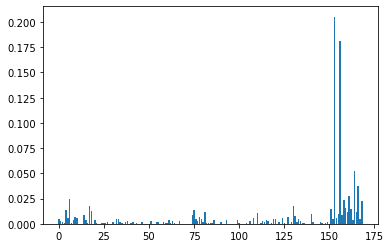

In [53]:
# plot
plt.bar(range(len(gridsearch.best_estimator_.named_steps['models'].feature_importances_)), gridsearch.best_estimator_.named_steps['models'].feature_importances_)
plt.show()